# 1. Image Transformation and Stitching

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# Load the images
image1 = cv2.imread("1.jpeg")
image2 = cv2.imread("2.jpeg")
image3 = cv2.imread("3.jpeg")
# Convert the images to RGB
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)


## Manual Identification
- We use predefined points for feature identification, which were generated in advance. If needed, you can run the `selection_identification.py` script to manually select points for feature identification.

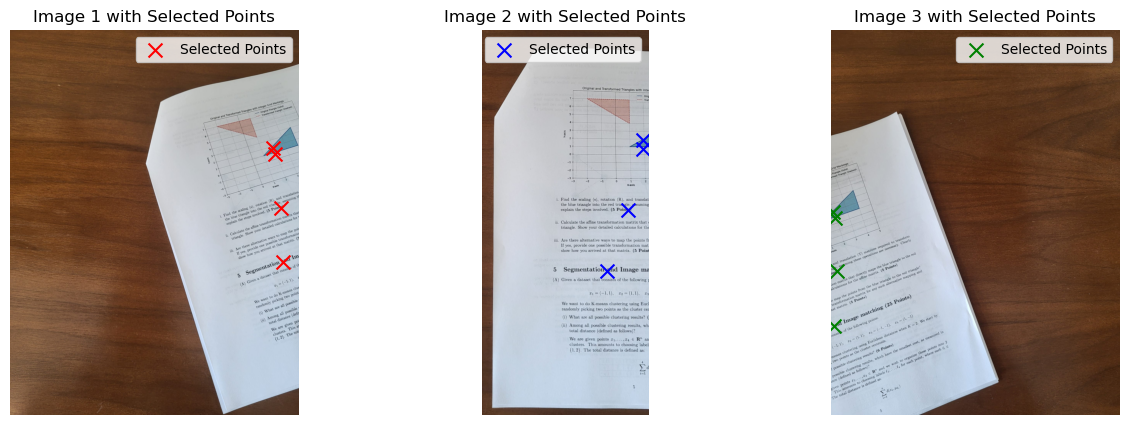

In [3]:

# Convert images from BGR (OpenCV default) to RGB for displaying in matplotlib
img1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
img3_rgb = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

# Step 3: Predefined points for feature identification
points_img1 = np.array([
    (1364.76, 611.51),
    (1376.12, 645.60),
    (1406.97, 923.20),
    (1416.71, 1205.67)
])
points_img2 = np.array([
    (860.41, 584.64),
    (860.41, 631.19),
    (777.29, 957.01),
    (665.92, 1279.50)
])
points_img3 = np.array([
    (14.11, 945.93),
    (20.60, 975.15),
    (30.34, 1252.75),
    (17.36, 1536.84)
])

# Step 4: Display images with the selected points
plt.figure(figsize=(15, 5))

# Image 1 with points
plt.subplot(1, 3, 1)
plt.imshow(img1_rgb)
plt.scatter(points_img1[:, 0], points_img1[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title("Image 1 with Selected Points")
plt.axis('off')
plt.legend()

# Image 2 with points
plt.subplot(1, 3, 2)
plt.imshow(img2_rgb)
plt.scatter(points_img2[:, 0], points_img2[:, 1], c='blue', marker='x', s=100, label='Selected Points')
plt.title("Image 2 with Selected Points")
plt.axis('off')
plt.legend()

# Image 3 with points
plt.subplot(1, 3, 3)
plt.imshow(img3_rgb)
plt.scatter(points_img3[:, 0], points_img3[:, 1], c='green', marker='x', s=100, label='Selected Points')
plt.title("Image 3 with Selected Points")
plt.legend()
plt.axis('off')
plt.show()


## Automated Detection

#### Feature Detection and Description Function
- This function detects and describes features in an image using either SIFT or ORB.
- It returns the keypoints and their corresponding feature descriptors.

In [4]:
def detectAndDescribe(image, method):
    if method == 'sift':
        descriptor = cv2.SIFT_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
    (kps, features) = descriptor.detectAndCompute(image, None)
    return (kps, features)

#### Create and return a Matcher Object

In [5]:
def createMatcher(method,crossCheck):

    if method == 'sift':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

#### Matcher Creation Function
- This function creates and returns a brute-force matcher object based on the selected method (SIFT or ORB).
- It configures the matcher to use the appropriate distance metric and cross-checking setting.

In [6]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
    best_matches = bf.match(featuresA,featuresB)
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    return rawMatches

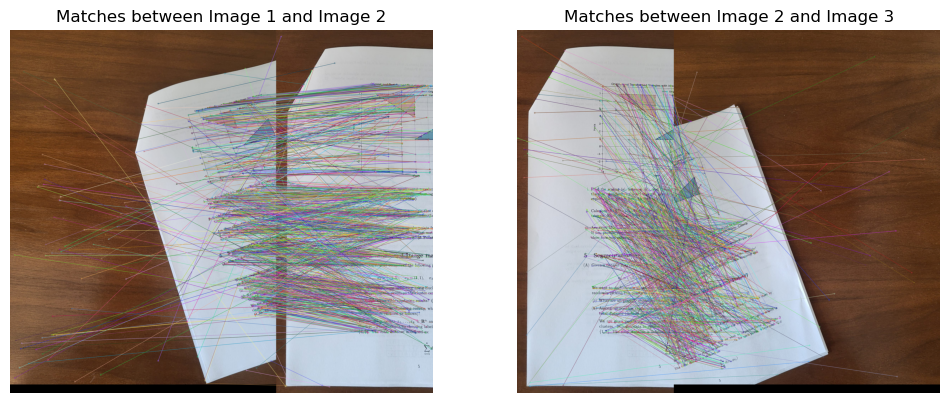

In [7]:
# Detect and describe the features
kps1, features1 = detectAndDescribe(image1, method='sift')
kps2, features2 = detectAndDescribe(image2, method='sift')
kps3, features3 = detectAndDescribe(image3, method='sift')

# Match the features
matches12 = matchKeyPointsBF(features1, features2, method='sift')
matches23 = matchKeyPointsBF(features2, features3, method='sift')

# Draw the matches
img_matches12 = cv2.drawMatches(image1, kps1, image2, kps2, matches12, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches23 = cv2.drawMatches(image2, kps2, image3, kps3, matches23, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Matches between Image 1 and Image 2")
plt.imshow(cv2.cvtColor(img_matches12, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Matches between Image 2 and Image 3")
plt.imshow(cv2.cvtColor(img_matches23, cv2.COLOR_BGR2RGB)) 
plt.axis('off')
plt.show()


#### Homography Computation Function
- This function computes the homography matrix that transforms points from one image to another.
- It uses RANSAC (Random Sample Consensus) to robustly estimate the homography by finding the best match
- between points while rejecting outliers based on a reprojection threshold.

In [8]:
def estimateHomography(keypointsA, keypointsB, match_pairs, threshold):
    # Convert the keypoints to numpy arrays
    keypointsA = np.float32([kp.pt for kp in keypointsA])
    keypointsB = np.float32([kp.pt for kp in keypointsB])

    if len(match_pairs) > 4:
        # Construct the two sets of points
        pointsA = np.float32([keypointsA[m.queryIdx] for m in match_pairs])
        pointsB = np.float32([keypointsB[m.trainIdx] for m in match_pairs])
        
        # RANSAC
        optimalH = None
        optimalStatus = None
        maxInliersCount = 0
        maxIterations = 5500  # Maximum number of iterations for RANSAC

        iterations = 0
    while iterations < maxIterations:
        # Randomly select 4 point pairs
        selected_indices = random.sample(range(len(pointsA)), 4)
        selected_ptsA = pointsA[selected_indices]
        selected_ptsB = pointsB[selected_indices]
        
        # Compute homography from these 4 points

        if len(selected_ptsA) != 4 or len(selected_ptsB) != 4:
            return None
        
        A = []
        for i in range(4):
            xA, yA = selected_ptsA[i]
            xB, yB = selected_ptsB[i]
            A.append([-xA, -yA, -1, 0, 0, 0, xA * xB, yA * xB, xB])
            A.append([0, 0, 0, -xA, -yA, -1, xA * yB, yA * yB, yB])
        
        A = np.array(A)
        
        # Solve for the homography matrix using SVD
        _, _, V = np.linalg.svd(A)
        h = V[-1]
        
        # Reshape to get the homography matrix
        homography = h.reshape(3, 3)
        if homography is None:
            continue
        
        # Compute the reprojection error for all points
        projected_pointsB = np.dot(homography, np.hstack((pointsA, np.ones((pointsA.shape[0], 1)))).T).T
        projected_pointsB = projected_pointsB[:, :2] / projected_pointsB[:, 2].reshape(-1, 1)  # Convert to homogeneous coordinates
        
        # Compute the reprojection errors
        reproj_errors = np.linalg.norm(projected_pointsB - pointsB, axis=1)
        
        # Identify inliers based on the threshold
        inlier_status = reproj_errors < threshold
        num_inliers = np.sum(inlier_status)
        
        # Keep track of the best homography with the maximum inliers
        if num_inliers > maxInliersCount:
            maxInliersCount = num_inliers
            optimalH = homography
            optimalStatus = inlier_status
        
        iterations += 1
    return (match_pairs, optimalH, optimalStatus)

#### the function of cutting the black part of the image

In [9]:
def rsGround(pic): # cut the black part of the image
    rows, cols = np.where(pic[:,:,0] !=0)
    min_row, max_row = min(rows), max(rows) +1
    min_col, max_col = min(cols), max(cols) +1
    return pic[min_row:max_row,min_col:max_col,:]

#### Main function for feature detection, matching, homography estimation, and image stitching
-  This function performs feature detection, feature matching, computes the homography matrix,
- and stitches two images together. The `feature_extractor` parameter allows selection of
- the feature extraction method (SIFT by default).

In [10]:
def swap(a, b): # swap the image
    return b,a

def singlePic(image1_path, image2_path, feature_method='sift'):
    # Load and preprocess images
    if isinstance(image2_path, str):
        img1 = cv2.imread(image2_path)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    else:
        img1 = image2_path
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)

    if isinstance(image1_path, str):
        img2 = cv2.imread(image1_path)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    else:
        img2 = image1_path
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    # Detect features and descriptors
    keypoints1, descriptors1 = detectAndDescribe(img1_gray, method=feature_method)
    keypoints2, descriptors2 = detectAndDescribe(img2_gray, method=feature_method)

    # Match features between images
    matched_points = matchKeyPointsBF(descriptors1, descriptors2, method=feature_method)
    match_img = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matched_points[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Estimate homography matrix
    match_count = len(matched_points)
    homography_matrix = estimateHomography(keypoints1, keypoints2, matched_points, 3)
    (matched_points, H, status) = homography_matrix

    # Warp the perspective of the first image
    stitched_result = cv2.warpPerspective(img1, H, ((img1.shape[1] + img2.shape[1]) * 2, (img1.shape[0] + img2.shape[0]) * 2))
    final_result = rsGround(stitched_result)
    
    # If the stitched result is too small, swap images
    if np.size(final_result) < np.size(img1) * 0.95:
        keypoints1, keypoints2 = swap(keypoints1, keypoints2)
        img1, img2 = swap(img1, img2)
        matched_points = matchKeyPointsBF(descriptors2, descriptors1, method=feature_method)
        match_count = len(matched_points)
        homography_matrix = estimateHomography(keypoints1, keypoints2, matched_points, 3)
        (matched_points, H, status) = homography_matrix
        stitched_result = cv2.warpPerspective(img1, H, ((img1.shape[1] + img2.shape[1]) * 2, (img1.shape[0] + img2.shape[0]) * 2))
    
    stitched_result[0:img2.shape[0], 0:img2.shape[1]] = np.maximum(img2, stitched_result[0:img2.shape[0], 0:img2.shape[1]])
    final_result = rsGround(stitched_result)  # Trim black parts of the image
    
    return final_result, match_count


def singlePicMulti(*images):
    num_images = len(images)
    assert(num_images > 1)
    matched_flags = [0 for _ in range(num_images - 1)]
    current_image = images[0]
    remaining_images = images[1:]
    
    for j in range(num_images - 1):
        has_match = False
        match_counts = []
        matched_images = []
        image_indexes = []
        
        for i in range(num_images - 1):
            if (matched_flags[i] == 1):
                continue
            result, match_count = singlePic(current_image, remaining_images[i])
            
            # Display the images in subplots
            plt.figure(figsize=(5, 5))
            plt.imshow(result)
            plt.axis('off')
            plt.show()
            
            if result is not None:
                match_counts.append(match_count)
                matched_images.append(result)
                image_indexes.append(i)
                has_match = True
        
        if not has_match:
            return None
        else:
            best_index = match_counts.index(max(match_counts))
            current_image = matched_images[best_index]
            matched_flags[image_indexes[best_index]] = 1
    
    return current_image


#### show wrapped images step by step

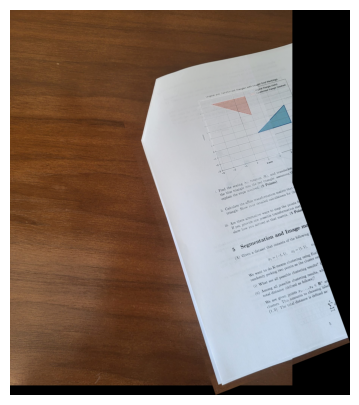

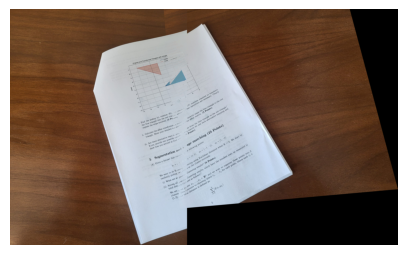

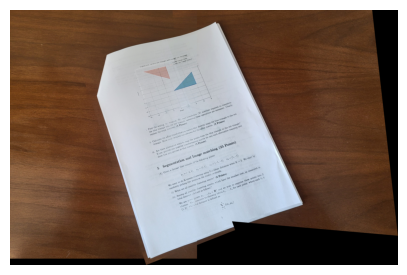

In [11]:
result = singlePicMulti("1.jpeg", "2.jpeg","3.jpeg")

#### display the result
-  Check if the result is good. If not, run again

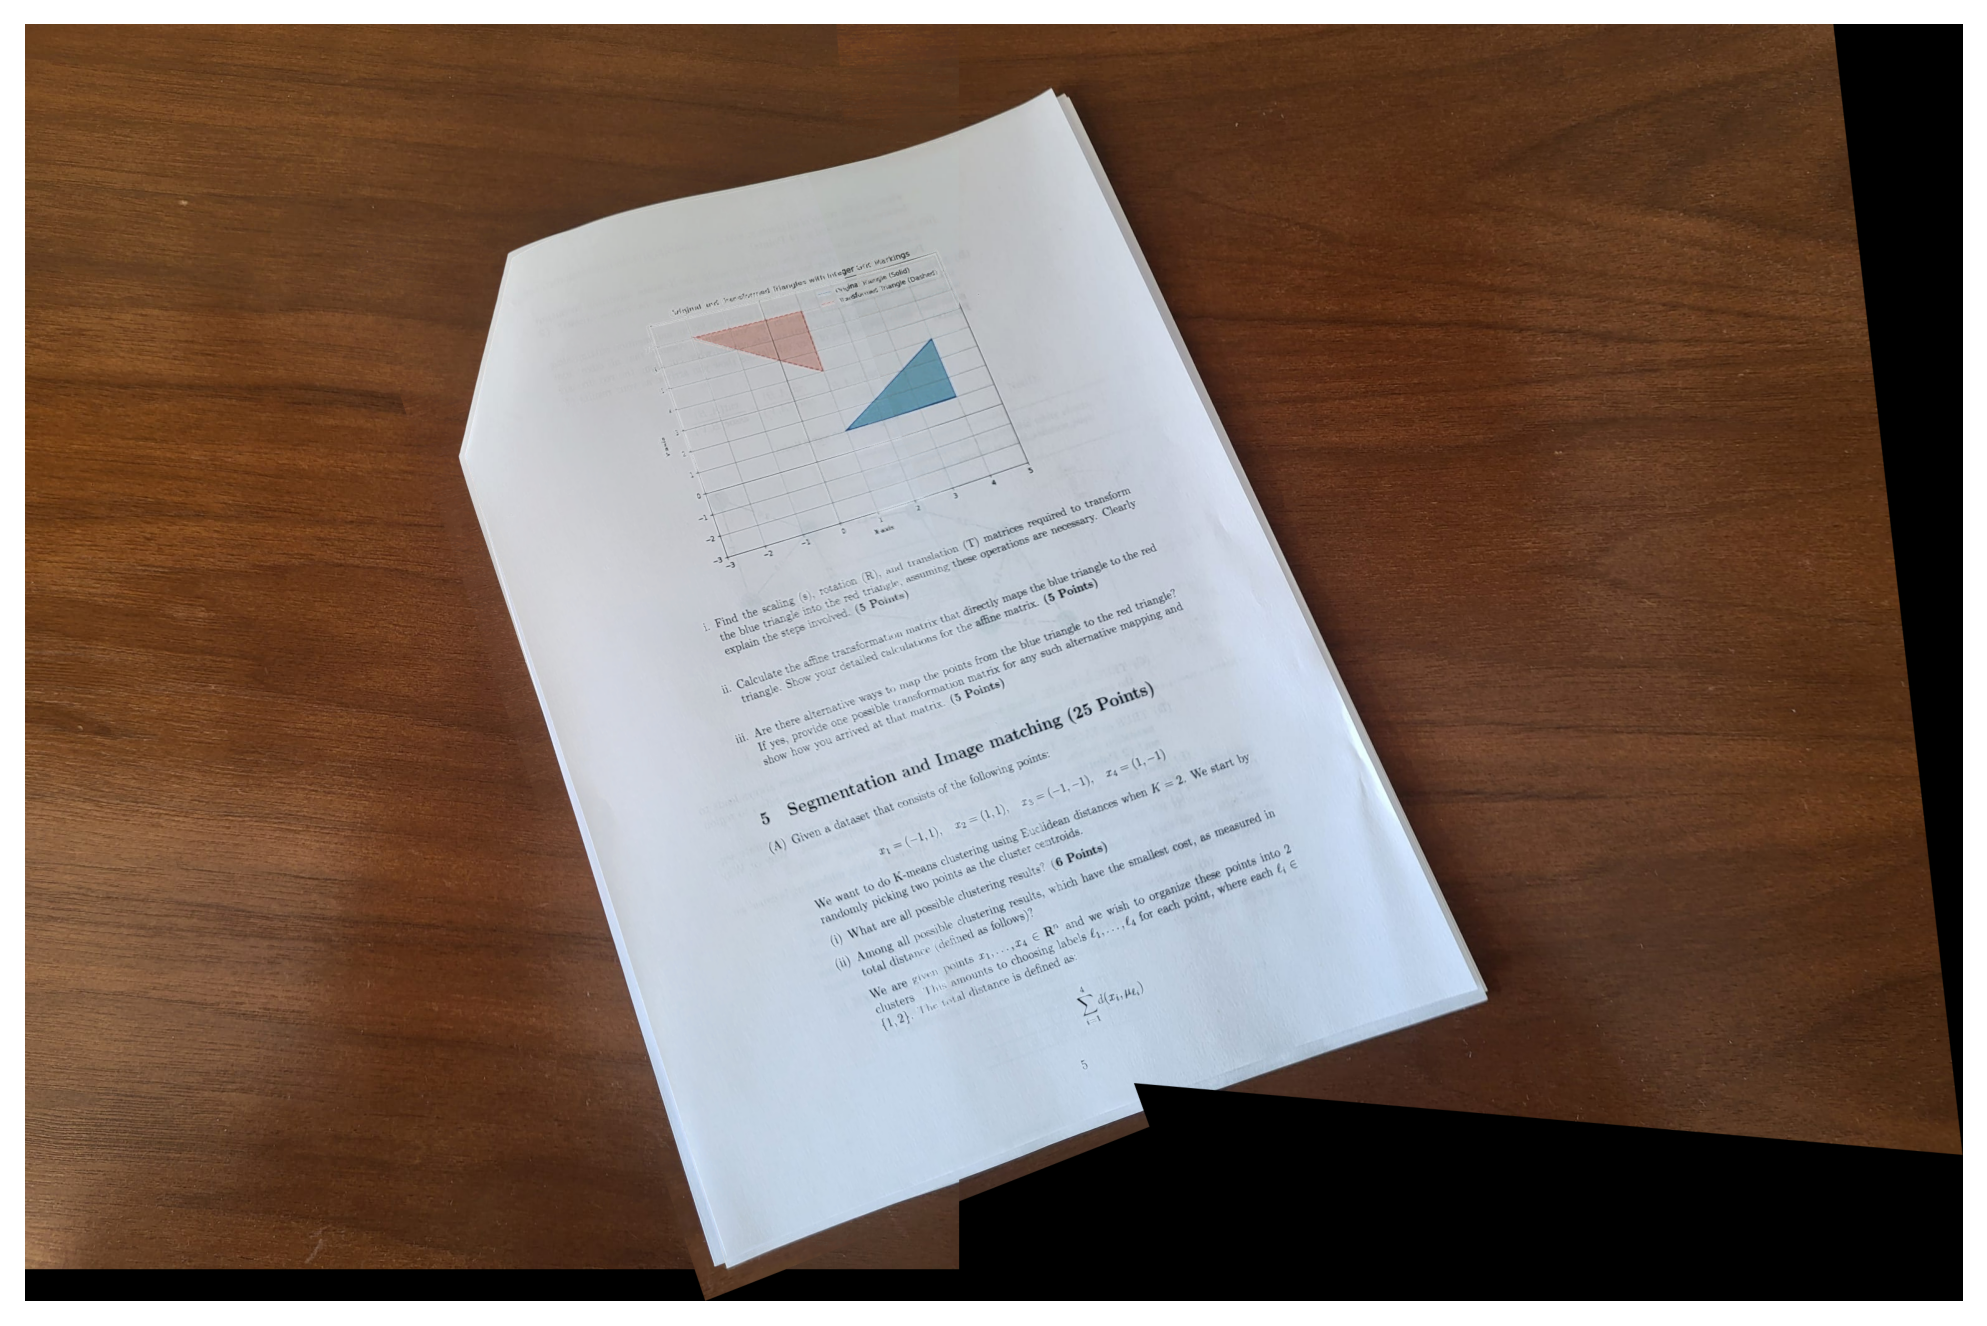

In [12]:
plt.figure(figsize=(10, 10), dpi=250)
plt.imshow(result)
plt.axis('off')
plt.show()

#### Comparison
 SIFT is efficient for large datasets, but manual matching is more accurate for specific, hard-to-detect features. The choice of method depends on the project requirements and the nature of the images being processed.